# Tugas Besar Pengantar Kecerdasan Buatan
## Anggota :
### Bagja 9102 Kurniawan - 1301194020
### Bella Adriani Putri - 1301194134

# Import Library 

In [1]:
# Generik & Manipulasi
import numpy as np 
import math
import random
import copy

# Plotting
#pip install plotly
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D

# Pembuatan Kelas

In [2]:
class Individu() : 
    def __init__(self, func, lenKromosom, batasanX, batasanY) :
        self.func = func 
        self.lenKromosom = lenKromosom 
        self.batasanX = batasanX 
        self.batasanY = batasanY 
        self.kromosom = np.random.randint(2, size=lenKromosom)
        self.updateStateIndividu() 

    def decodefrombin(self, kromosom, rmin, rmax) : 
        """
        fungsi ini mengubah kromosom biner menjadi nilai riil
        """
        n = len(kromosom)
        sigm = 0
        sum = 0
        for i, gen in enumerate(kromosom): 
            sigm += math.pow(2, -(i+1))
            sum += gen * math.pow(2, -(i+1))
        return rmin + ((rmax - rmin)/sigm * sum)

    def updateStateIndividu(self) : 
        """
        metode ini menetapkan x dan y menggunakan fungsi decodefrombin dan menghitung nilai fitness dan nilai fungsi
        """
        self.x = self.decodefrombin(self.kromosom[0:len(self.kromosom)//2], self.batasanX[0], self.batasanX[1])
        self.y = self.decodefrombin(self.kromosom[len(self.kromosom)//2 :], self.batasanY[0], self.batasanY[1])
        self.hx = self.func(self.x, self.y) 
        self.fitness = self.hx

    def update_gen(self, new) : 
        """
        metode ini digunakan untuk memperbarui kromosom dengan kromosom baru
        """
        self.kromosom = new 
        self.updateStateIndividu()

class populasi() : 
    def __init__(self, size, func, lenKromosom, batasanX, batasanY) : 
        self.size = size 
        self.individu = self.init_populasi(func, lenKromosom, batasanX, batasanY)
        self.updateStatePopulasi() 

    def init_populasi(self, func, lenKromosom, batasanX, batasanY) : 
        """
        inisialisasi populasi dengan ukuran dari self.size
        """
        individu = []
        for i in range(self.size): 
            individu.append(Individu(func, lenKromosom, batasanX, batasanY))
        return np.array(individu) 

    def updateStatePopulasi(self) : 
        """
        perbarui state populasi seperti bestFit
        least bestFit, dan second least bestFit 

        digunakan sebelum berubah menjadi generasi yang lebih baru
        """
        self.individu = sorted(self.individu, key=lambda x: x.fitness, reverse=True) 
        self.bestFit = self.individu[0]
        self.least_bestFit = self.individu[-1]
        self.second_least_bestFit = self.individu[-2]


class GADriver() : 

    def __init__(self, populasi, pc, pm) : 
        self.pop = populasi
        self.pc = pc
        self.pm = pm

    def stochastic_roulette(self) :
        """
        metode pemilihan parent dengan stochastic roulette wheel
        """
        _min = min(individu.fitness for individu in self.pop.individu)
        _sum = sum(individu.fitness + abs(_min) + 0.01 for individu in self.pop.individu)
        _max = max(individu.fitness + abs(_min) + 0.01 for individu in self.pop.individu)
        
        def getidx() : 
            while True :
                indv = random.randint(0, self.pop.size - 1) 
                r = random.uniform(0, 1)
                if (r < (self.pop.individu[indv].fitness + abs(_min))/_max) : 
                    p = indv 
                    break
            return p

        self.parent = copy.copy(self.pop.individu[getidx()])
        self.second_parent = copy.copy(self.pop.individu[getidx()])

    def uniform_crossover(self) :
        """
        Metode ini mengembalikan hasil uniform crossover dengan pola antar dua kromosom 
        yang mana ialah kromosom parent dan parent kedua
        
        fungsi ini mengembalikan dua buah kromosom baru, offspring1 dan offspring2
        """

        pola = np.random.randint(2, size=self.pop.bestFit.lenKromosom)
        c1 = copy.copy(self.parent.kromosom)
        c2 = copy.copy(self.second_parent.kromosom)

        for i in range(len(c1)) : 
            if pola[i] == 1 : 
                c1[i], c2[i] = c2[i], c1[i]

        return c1, c2
            
    def mutation(self, c1, c2) :
        """
        Metode ini mengembalikan hasil mutasi loop melalui gen, 
        jika probabilitas randomnya 1 maka terjadi mutasi,
        gen yang bernilai 1 akan berubah menjadi 0 sedangkan jika 0 akan berubah menjadi 1
        
        fungsi ini mengembalikan dua buah kromosom baru, offspring1 dan offspring2
        """

        for i in range(self.pop.bestFit.lenKromosom) :
            rand = random.choices([0, 1], [(1 - self.pm), self.pm])[0]
            if rand == 1 : 
                c1[i] = 1 if c1[i] == 0 else 0 
                c2[i] = 1 if c2[i] == 0 else 0 

        return c1, c2

    def infoFitnessTerbaik(self) : 
        print('+'+"="*5+" Fitness terbaik yang didapat! "+"="*5+'+')
        print("kromosom : ", self.pop.bestFit.kromosom)
        print("x          : ", self.pop.bestFit.x)
        print("y          : ", self.pop.bestFit.y)
        print("Fitness    : ", self.pop.bestFit.fitness)

    def train(self, n_gen) :
        
        # parent selection methods 
        fit_history = []
        val_history = [] 
        x_history  = []
        y_history  = []

        it = 1
        for i in range(n_gen) : 

            
            fit_history.append(self.pop.bestFit.fitness)
            val_history.append(self.pop.bestFit.hx)
            x_history.append (self.pop.bestFit.x)
            y_history.append (self.pop.bestFit.y)

            print('\n+'+"="*5+" Gen-{} ".format(it)+"="*5+'+')
            print("Nilai Fitness Terbaik")
            print("kromosom   : ", self.pop.bestFit.kromosom)
            print("x          : ", self.pop.bestFit.x)
            print("y          : ", self.pop.bestFit.y)
            print("Fitness    : ", self.pop.bestFit.fitness)

            # roulette, get two parents
            self.stochastic_roulette()

            # crossover, return two offsprings
            offspring1, offspring2 = self.uniform_crossover()

            # mutation, return mutated two offsprings
            offspring1, offspring2 = self.mutation(offspring1, offspring2) 

            # Steady State, replace two worst fitness chromosome with newest offspring
            self.pop.least_bestFit.update_gen(offspring1) 
            self.pop.second_least_bestFit.update_gen(offspring2)

            # update state, bestFit, least_bestFit, second_bestFit
            self.pop.updateStatePopulasi()

            it+=1

        return fit_history, val_history, x_history, y_history

# Mathematical Function

In [3]:
def h_func(x, y) : 
  return math.cos(math.radians(pow(x,2))) * math.sin(math.radians(pow(y,2))) + (x + y)

func = h_func

# Parameters Setting 

In [4]:
# ukuran populasi
size=60

# panjang kromosom
lenKromosom=30

# rmin, rmax
batasanX = [-1, 2]
batasanY = [-1, 1]

# peluang crossover
pc = 0.9

# peluang mutasi
pm = 0.1

# banyaknya generasi
n_gen=1945

# inisialisasi object
populasi = populasi(size, func, lenKromosom, batasanX, batasanY)
driver = GADriver(populasi, pc, pm)
fit_history, val_history, x_history, y_history = driver.train(n_gen)


+===== Gen-1 =====+
Nilai Fitness Terbaik
kromosom   :  [1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0]
x          :  1.9614551225318158
y          :  0.8136539811395611
Fitness    :  2.7866374598188997

+===== Gen-2 =====+
Nilai Fitness Terbaik
kromosom   :  [1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0]
x          :  1.9614551225318158
y          :  0.8136539811395611
Fitness    :  2.7866374598188997

+===== Gen-3 =====+
Nilai Fitness Terbaik
kromosom   :  [1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0]
x          :  1.9614551225318158
y          :  0.8136539811395611
Fitness    :  2.7866374598188997

+===== Gen-4 =====+
Nilai Fitness Terbaik
kromosom   :  [1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0]
x          :  1.9614551225318158
y          :  0.8136539811395611
Fitness    :  2.7866374598188997

+===== Gen-5 =====+
Nilai Fitness Terbaik
kromosom   :  [1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0]
x        

# Visualisasi

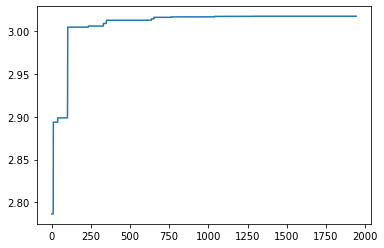

In [5]:
plt.plot(fit_history)

In [6]:
x = np.linspace(-1, 2, num=100)
y = np.linspace(-1, 1, num=100)
xx, yy = np.meshgrid(x, y)
zz = np.cos(np.radians(pow(xx,2))) * np.sin(np.radians(pow(yy,2))) + (xx + yy)

In [7]:
fit_history[-1]

3.017409893252357

In [8]:
x_history[-1]

2.0

In [9]:
y_history[-1]

1.0

In [10]:
# Output
driver.infoFitnessTerbaik()

+===== Fitness terbaik yang didapat! =====+
kromosom :  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
x          :  2.0
y          :  1.0
Fitness    :  3.017409893252357


In [11]:
zz

array([[-1.98255025, -1.95224691, -1.9219436 , ...,  0.95680875,
         0.98710938,  1.01740989],
       [-1.96304608, -1.93274276, -1.90243946, ...,  0.97631432,
         1.00661504,  1.03691566],
       [-1.94352768, -1.91322437, -1.88292108, ...,  0.99583409,
         1.02613491,  1.05643562],
       ...,
       [-0.02433576,  0.00596755,  0.03627084, ...,  2.91502601,
         2.94532683,  2.97562754],
       [-0.00345012,  0.0268532 ,  0.0571565 , ...,  2.93591028,
         2.966211  ,  2.99651161],
       [ 0.01744975,  0.04775309,  0.0780564 , ...,  2.95680875,
         2.98710938,  3.01740989]])

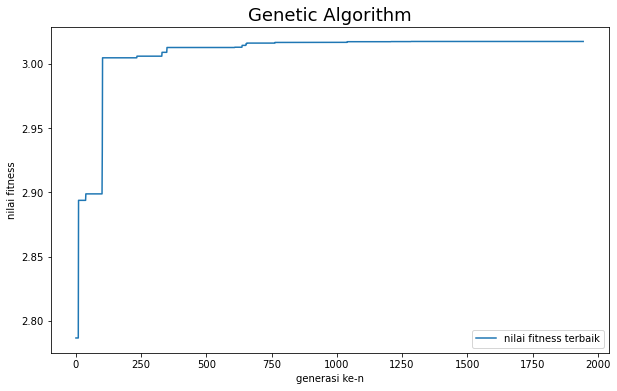

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(fit_history, label='nilai fitness terbaik')
ax.set_xlabel("generasi ke-n")
ax.set_ylabel("nilai fitness")
ax.set_title("Genetic Algorithm", fontsize=18)

ax.legend()

<ipython-input-13-01e8d2e1498b>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


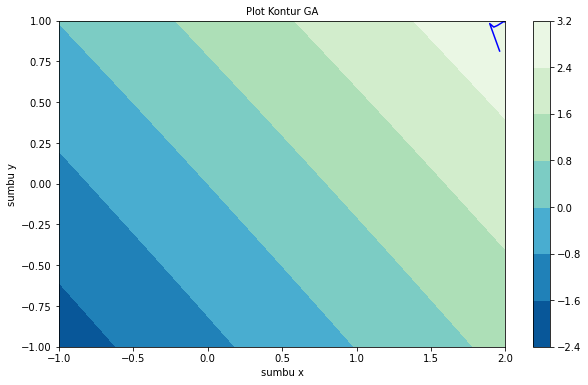

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
temp = ax.contourf(xx, yy, zz, cmap='GnBu_r')
ax.set_xlabel('sumbu x')
ax.set_ylabel('sumbu y')
ax.set_title('Plot Kontur GA', fontsize=10)

ax.plot(x_history, y_history, color='b')
fig.colorbar(temp)

fig.show()
fig.savefig("contour")

<ipython-input-14-5638aac36260>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


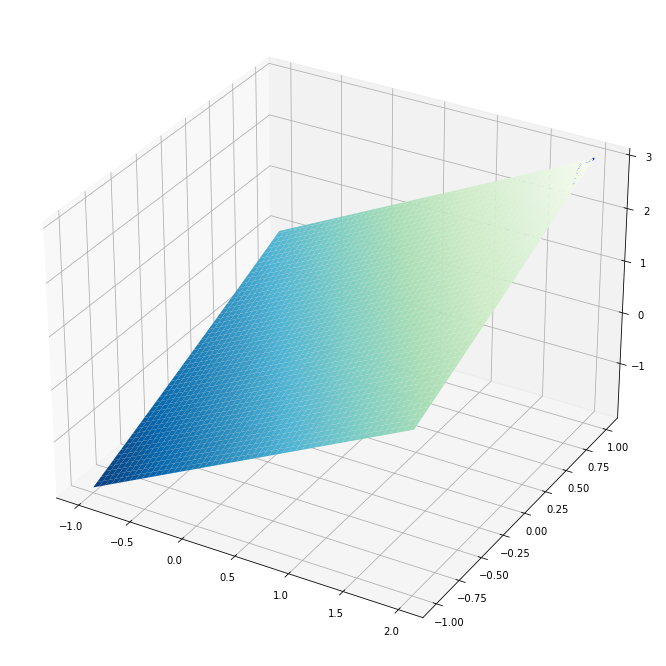

In [14]:
fig = plt.figure(figsize=(26,12)) 
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zz, cmap='GnBu_r', edgecolor='none')
ax.plot(x_history, y_history, val_history, color='b')

fig.show()
fig.savefig("3dplot")